# Value Per Possession Year over Year

Does the "value per possession" metric correlate from one year to the next for a player?

TL;DR, yeah

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd

from endgame.ncaabb.box_score import BoxScore
from individual_players.players import get_player_performances

In [3]:
sport = 'ncaambb'

In [4]:
# Maybe this isn't the best way to store this data
# ...but hey, multiprocessing gets it done quickly
with open(f"data/{sport}_box.json") as file:
    raw_boxes = json.load(file)
with Pool(cpu_count() - 1) as pool:
    box_scores = pool.map(BoxScore.from_dict, raw_boxes)

In [ ]:
box_score_lookup = {
    int(b.game_id): b for b in box_scores
}

In [6]:
games = pd.read_csv(f'./data/{sport}.csv')

In [7]:
all_performances = []
columns = ['player', 'value', 'game_id', 'team_id', 'possessions']
for season, season_games in games.groupby('season'):
    game_box_scores = []
    for game_id in season_games.game_id:
        box_score = box_score_lookup.get(game_id)
        if box_score is not None:
            game_box_scores.append(box_score)
    if not game_box_scores:
        continue
    performances = get_player_performances(game_box_scores)
    for performance in performances:
        d = dict(zip(columns, performance))
        d['season'] = season
        all_performances.append(d)

In [8]:
df = pd.DataFrame(all_performances)

In [9]:
player_seasons = df.groupby(['player', 'season']).agg(['sum', 'count'])[['value', 'possessions']]
player_seasons.columns = ['_'.join(col).strip() for col in player_seasons.columns.values]
player_seasons = player_seasons.reset_index()
player_seasons['vpp'] = player_seasons.value_sum / player_seasons.possessions_sum
player_seasons['previous_season'] = player_seasons.season - 1

In [10]:
lookup = {
    (row.player, row.season): row.vpp
    for row in player_seasons.itertuples()
    if row.possessions_count > 20
}

In [11]:
player_seasons['previous_vpp'] = [
    lookup.get((row.player, row.previous_season), np.nan)
    for row in player_seasons.itertuples()
]

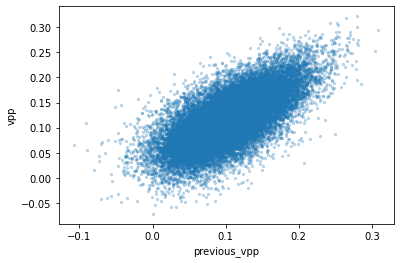

In [12]:
player_seasons[player_seasons.possessions_count > 20].plot.scatter('previous_vpp', 'vpp', s=5, alpha=.25);

In [13]:
df.to_csv(f'data/{sport}_values.csv', index=False)

In [14]:
vpp = player_seasons[player_seasons.possessions_count > 20].vpp
previous_vpp = player_seasons[player_seasons.possessions_count > 20].previous_vpp
vpp = vpp[~np.isnan(previous_vpp)]
previous_vpp = previous_vpp[~np.isnan(previous_vpp)]


In [15]:
np.corrcoef(vpp, previous_vpp)

array([[1.        , 0.68489342],
       [0.68489342, 1.        ]])